In [1]:
import pandas as pd
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import nltk
import time
import tracemalloc

In [2]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\samys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# Load data with utf-8 encoding
with open(r'D:\aip\Findata\train1.json', 'r', encoding='utf-8') as file1, open(r'D:\aip\Findata\train_t.json', 'r', encoding='utf-8') as file2:
    data1 = pd.read_json(file1)
    data2 = pd.read_json(file2)



In [4]:
print(data1.columns)

Index(['table', 'paragraphs', 'questions'], dtype='object')


In [5]:
rows = []
for _, row in data1.iterrows():
    # Access the 'questions' column, which contains the list of question dictionaries
    if isinstance(row['questions'], list):  # Ensure it's a list
        for question in row['questions']:
            x = question['question']  # Extract the question text
            y = 'contextual' if question['answer_from'] == 'text' else 'numerical'
            rows.append((x, y))

# Create a DataFrame
df1 = pd.DataFrame(rows, columns=['X', 'y'])
print(df1.head())

                                                   X          y
0  What does the Weighted average actuarial assum...  numerical
1            How much is the 2019 rate of inflation?  numerical
2            How much is the 2018 rate of inflation?  numerical
3        What is the 2019 average rate of inflation?  numerical
4  What is the 2019 average rate of increase in s...  numerical


In [6]:
df1.shape

(13215, 2)

In [7]:
# Create DataFrame for train_t.json
rows = []
for _, row in data2.iterrows():
    if 'qa' in row and isinstance(row['qa'], dict):  # Ensure 'qa' column exists and is a dict
        question = row['qa'].get('question', None)  # Extract the 'question'
        if question:  # Only process if the question exists
            rows.append((question, 'numerical'))
df2 = pd.DataFrame(rows, columns=['X', 'y'])

In [8]:
df2.shape

(7462, 2)

In [9]:
df2

,X,y
0,what was the percentage change in the net cash...,numerical
1,what was the percentage change in the net cash...,numerical
2,what was the percentage change in the net cash...,numerical
3,what was the percentage change in the net cash...,numerical
4,what was the percent of the growth in the reve...,numerical
...,...,...
7457,what is the percentage change in gross unpaid ...,numerical
7458,what is the percentage change in gross unpaid ...,numerical
7459,what is the percentage change in gross unpaid ...,numerical
7460,"what was the average capital expenditures , in...",numerical


In [10]:
df = pd.concat([df1, df2], ignore_index=True)

In [11]:
df.shape

(20677, 2)

In [12]:
# Remove duplicate rows
df = df.drop_duplicates()

# Verify the result
print(f"Number of rows after removing duplicates: {len(df)}")
print(df.head())


Number of rows after removing duplicates: 14792
                                                   X          y
0  What does the Weighted average actuarial assum...  numerical
1            How much is the 2019 rate of inflation?  numerical
2            How much is the 2018 rate of inflation?  numerical
3        What is the 2019 average rate of inflation?  numerical
4  What is the 2019 average rate of increase in s...  numerical


In [13]:
def extract_questions_answers(file_path):
    # Create an empty DataFrame to store all questions and answers
    all_data = pd.DataFrame(columns=['X', 'y'])
    
    # Load the Excel file
    excel_file = pd.ExcelFile(file_path)
    
    # Iterate through each sheet
    for sheet_name in excel_file.sheet_names:
        # Read the sheet data
        sheet_data = pd.read_excel(excel_file, sheet_name=sheet_name)
        
        # Check if the sheet has the expected structure
        if 'Question' in sheet_data.columns and 'Answer' in sheet_data.columns:
            # Extract questions and answers
            questions = sheet_data['Question'].dropna()
            
            # Create a temporary DataFrame for this sheet
            temp_df = pd.DataFrame({
                'X': questions,
                'y': "numerical"
            })
            
            # Append to the main DataFrame
            all_data = pd.concat([all_data, temp_df], ignore_index=True)
        else:
            print(f"Sheet '{sheet_name}' doesn't have the expected structure. Skipping.")
    
    return all_data

# Use your specific file path
file_path = r'D:\aip\qadata.xlsx'
df3 = extract_questions_answers(file_path)

# Display the first few rows to verify
print(df3.head())

                                                   X          y
0     How much revenue did Meta generate in Q3 2024?  numerical
1             What was Meta’s net income in Q3 2024?  numerical
2  What were the total operating expenses for Met...  numerical
3  How much did Meta spend on research and develo...  numerical
4  What was Meta’s earnings per share (EPS) in Q3...  numerical


In [14]:
df3.shape

(400, 2)

In [15]:
import os

def process_csv_files(directory_path):
    # Create an empty DataFrame to store all questions
    all_data = pd.DataFrame(columns=['X', 'y'])
    
    # Get list of all CSV files in the directory
    csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    
    # Loop through each CSV file
    for file_name in csv_files:
        file_path = os.path.join(directory_path, file_name)
        
        try:
            # Read the CSV file
            df = pd.read_csv(file_path)
            
            # Find the question column (might have different names in different files)
            question_col = None
            for col in df.columns:
                if 'question' in col.lower():
                    question_col = col
                    break
            
            # If question column found, extract questions
            if question_col:
                # Filter out NaN values if any
                questions = df[question_col].dropna()
                
                # Create a temporary DataFrame for this file
                temp_df = pd.DataFrame({
                    'X': questions,
                    'y': 'contextual'  # Set "contextual" string for all entries
                })
                
                # Append to the main DataFrame
                all_data = pd.concat([all_data, temp_df], ignore_index=True)
                print(f"Processed {len(questions)} questions from {file_name}")
            else:
                print(f"Could not find question column in {file_name}")
        
        except Exception as e:
            print(f"Error processing {file_name}: {str(e)}")
    
    return all_data

# Use your specific directory path
directory_path = r'D:\aip\rag_questions'
df4 = process_csv_files(directory_path)

# Display the count of questions processed
print(f"\nTotal questions processed: {len(df4)}")


Processed 24 questions from additional_questions_answers.csv
Processed 200 questions from heavy_200_QA_Pairs.csv
Processed 24 questions from ipg_questions_answers.csv
Processed 14 questions from more_questions_answers.csv
Processed 18 questions from new_questions_answers.csv
Processed 25 questions from questions_answers.csv

Total questions processed: 305


In [16]:
def balance_dataset(df, target_size_per_class=2000):
    print(f"Original dataset size: {len(df)}")
    print(f"Class distribution:\n{df['y'].value_counts()}")
    
    # Separate the dataset by class
    contextual_df = df[df['y'] == 'contextual']
    numerical_df = df[df['y'] == 'numerical']
    
    print(f"Found {len(contextual_df)} contextual questions")
    print(f"Found {len(numerical_df)} numerical questions")
    
    # Randomly sample the specified number from each class
    if len(contextual_df) >= target_size_per_class:
        sampled_contextual = contextual_df.sample(n=target_size_per_class, random_state=42)
    else:
        print(f"Warning: Only {len(contextual_df)} contextual questions available, using all of them")
        sampled_contextual = contextual_df
    
    if len(numerical_df) >= target_size_per_class:
        sampled_numerical = numerical_df.sample(n=target_size_per_class, random_state=42)
    else:
        print(f"Warning: Only {len(numerical_df)} numerical questions available, using all of them")
        sampled_numerical = numerical_df
    
    # Combine the sampled data
    balanced_df = pd.concat([sampled_contextual, sampled_numerical], ignore_index=True)
    
    # Shuffle the combined dataset
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"Final balanced dataset size: {len(balanced_df)}")
    print(f"Final class distribution:\n{balanced_df['y'].value_counts()}")
    
    return balanced_df

# Usage with your existing DataFrame
# Just call the function with your existing df variable
balanced_df = balance_dataset(df, target_size_per_class=2000)


Original dataset size: 14792
Class distribution:
y
numerical     11807
contextual     2985
Name: count, dtype: int64
Found 2985 contextual questions
Found 11807 numerical questions
Final balanced dataset size: 4000
Final class distribution:
y
contextual    2000
numerical     2000
Name: count, dtype: int64


In [17]:
combined_df = pd.concat([balanced_df, df3, df4], ignore_index=True)

# Display information about the combined DataFrame
print(f"Original balanced_df size: {len(balanced_df)}")
print(f"df3 size: {len(df3)}")
print(f"df4 size: {len(df4)}")
print(f"Combined DataFrame size: {len(combined_df)}")

# Check class distribution in the combined DataFrame
print(f"Combined class distribution:\n{combined_df['y'].value_counts()}")

Original balanced_df size: 4000
df3 size: 400
df4 size: 305
Combined DataFrame size: 4705
Combined class distribution:
y
numerical     2400
contextual    2305
Name: count, dtype: int64


In [18]:
# Preprocessing function
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [19]:
#Apply preprocessing
combined_df['X'] = combined_df['X'].apply(preprocess)

# Encode target column
combined_df['y'] = combined_df['y'].map({'numerical': 1, 'contextual': 0})

In [22]:
combined_df['X']

0              what are the revenue and net loss for 2019
1            what wa the provision for income tax in 2019
2       why did the federal statutory rate in fiscal y...
3       what wa the percentage change in net earnings ...
4       what wa the percentage cumulative total shareh...
                              ...                        
4700    what wa the primary reason for the decrease in...
4701    what wa the impact of the storm damage rider o...
4702    what wa the total intrinsic value of rsus vest...
4703    what wa the total unrecognized compensation co...
4704    what method doe adobe use to account for incom...
Name: X, Length: 4705, dtype: object

In [23]:
combined_df['y']

0       0
1       1
2       0
3       1
4       1
       ..
4700    0
4701    0
4702    0
4703    0
4704    0
Name: y, Length: 4705, dtype: int64

In [24]:
combined_df['y'].value_counts()

y
1    2400
0    2305
Name: count, dtype: int64

In [25]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=20000, min_df=5, max_df=0.7)
X = tfidf.fit_transform(combined_df['X'])

In [26]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, combined_df['y'], test_size=0.2, random_state=42)

In [27]:
# Train models
xgb_model = XGBClassifier()
svm_model = SVC(probability=True)
rf_model = RandomForestClassifier()

xgb_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [28]:
# Evaluate models
models = {
    'XGBoost': xgb_model,
    'SVM': svm_model,
    'Random Forest': rf_model
}


In [29]:
for name, model in models.items():
    print(f"Evaluating {name}...")

    # Measure memory usage
    tracemalloc.start()
    start_time = time.time()

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    auc_score = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'

    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {auc_score}")
    print(f"Memory Usage: Current = {current / 10**6:.2f} MB, Peak = {peak / 10**6:.2f} MB")
    print(f"Prediction Time: {end_time - start_time:.4f} seconds")
    print("-" * 50)

Evaluating XGBoost...
Model: XGBoost
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       460
           1       0.86      0.86      0.86       481

    accuracy                           0.86       941
   macro avg       0.86      0.86      0.86       941
weighted avg       0.86      0.86      0.86       941

AUC Score: 0.9376163789207269
Memory Usage: Current = 0.03 MB, Peak = 0.04 MB
Prediction Time: 0.0049 seconds
--------------------------------------------------
Evaluating SVM...
Model: SVM
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       460
           1       0.90      0.88      0.89       481

    accuracy                           0.89       941
   macro avg       0.89      0.89      0.89       941
weighted avg       0.89      0.89      0.89       941

AUC Score: 0.952962577962578
Memory Usage: Current = 0.02 MB, Peak = 0.03 MB
Prediction Time: 0.5454 seconds
----------

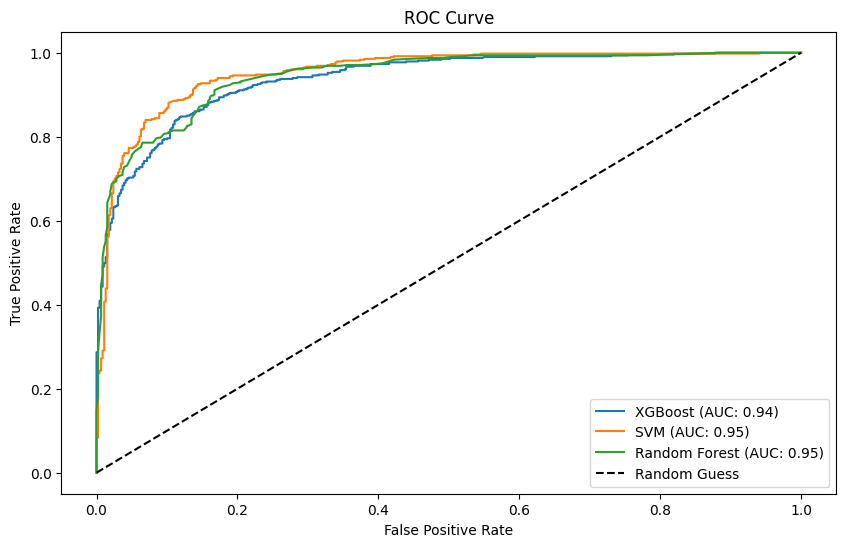

In [30]:
# Visualize AUC scores
plt.figure(figsize=(10, 6))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc_score(y_test, y_prob):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [31]:
for name, model in models.items():
    print(f"Evaluating {name}...")

    # Measure memory usage
    tracemalloc.start()
    start_time = time.time()

    y_pred = model.predict(X_train)
    y_prob = model.predict_proba(X_train)[:, 1] if hasattr(model, 'predict_proba') else None

    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    auc_score = roc_auc_score(y_train, y_prob) if y_prob is not None else 'N/A'

    print(f"Model: {name}")
    print(classification_report(y_train, y_pred))
    print(f"AUC Score: {auc_score}")
    print(f"Memory Usage: Current = {current / 10**6:.2f} MB, Peak = {peak / 10**6:.2f} MB")
    print(f"Prediction Time: {end_time - start_time:.4f} seconds")
    print("-" * 50)

Evaluating XGBoost...
Model: XGBoost
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1845
           1       0.98      0.97      0.97      1919

    accuracy                           0.97      3764
   macro avg       0.97      0.97      0.97      3764
weighted avg       0.97      0.97      0.97      3764

AUC Score: 0.9967738108855815
Memory Usage: Current = 0.07 MB, Peak = 0.10 MB
Prediction Time: 0.0070 seconds
--------------------------------------------------
Evaluating SVM...
Model: SVM
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1845
           1       0.98      0.98      0.98      1919

    accuracy                           0.98      3764
   macro avg       0.98      0.98      0.98      3764
weighted avg       0.98      0.98      0.98      3764

AUC Score: 0.9979386000217481
Memory Usage: Current = 0.09 MB, Peak = 0.09 MB
Prediction Time: 2.1352 seconds
---------

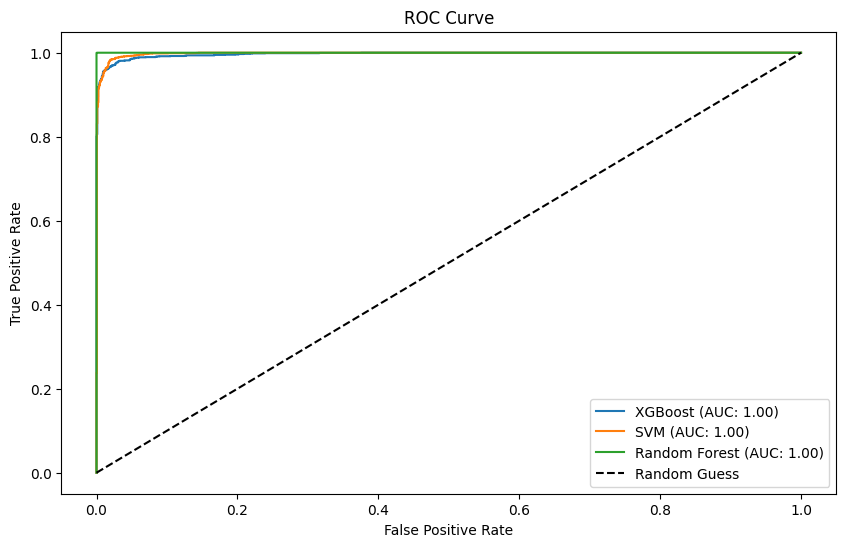

In [32]:
# Visualize AUC scores
plt.figure(figsize=(10, 6))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_train)[:, 1]
        fpr, tpr, _ = roc_curve(y_train, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc_score(y_train, y_prob):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [49]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2',None]
}

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1',  # Use F1-score for imbalanced datasets
    cv=5,          # 5-fold cross-validation
    n_jobs=-1,     # Use all available cores
    verbose=1      # Print progress
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Evaluate on test set
y_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       460
           1       0.83      0.86      0.85       481

    accuracy                           0.84       941
   macro avg       0.84      0.84      0.84       941
weighted avg       0.84      0.84      0.84       941



In [34]:
def predict_single_input(model, input_text, tfidf_vectorizer):
    """
    Predict the class of a single input and measure the prediction time.

    Args:
        model: Trained machine learning model (e.g., XGBoost, SVM, Random Forest).
        input_text: A single string input for prediction.
        tfidf_vectorizer: The fitted TF-IDF vectorizer used for preprocessing.

    Returns:
        result: Predicted class.
        prediction_time: Time taken for the prediction in seconds.
        memory_usage: Memory used during prediction (current and peak in MB).
    """
    # Preprocess the input text
    preprocessed_text = preprocess(input_text)

    # Transform input text using TF-IDF vectorizer
    input_vectorized = tfidf_vectorizer.transform([preprocessed_text])

    # Measure prediction time and memory usage
    tracemalloc.start()
    start_time = time.time()

    prediction = model.predict(input_vectorized)

    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    prediction_time = end_time - start_time
    memory_usage = (current / 10**6, peak / 10**6)  # Convert bytes to MB

    return prediction[0], prediction_time, memory_usage

In [52]:
input_text = "What was the revenue of the company in 2024"
result, time_taken, memory = predict_single_input(best_rf_model, input_text, tfidf)
print(f"Prediction: {result}, Time Taken: {time_taken:.4f} seconds, Memory Usage: Current = {memory[0]:.2f} MB, Peak = {memory[1]:.2f} MB")


Prediction: 1, Time Taken: 0.0179 seconds, Memory Usage: Current = 0.01 MB, Peak = 0.02 MB


In [53]:
import pickle

# Path for saving the Random forest model
rf_model_path = 'rf_model.pkl'
vectorizer_path = 'tfidf_vectorizer.pkl'
preprocessor_path = 'preprocessor.pkl'

# Save the rf model
with open(rf_model_path, 'wb') as f:
    pickle.dump(best_rf_model, f)
    print(f"Saved Random forest model to {rf_model_path}")

# Save TF-IDF vectorizer
with open(vectorizer_path, 'wb') as f:
    pickle.dump(tfidf, f)
    print(f"Saved TF-IDF vectorizer to {vectorizer_path}")

# Save preprocessing function
# Serialize preprocessing function using joblib
preprocessing_code = r'''
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    """Preprocess the input text."""
    text = text.lower()  # Lowercase
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)
'''

with open(preprocessor_path, 'w') as f:
    f.write(preprocessing_code)
    print(f"Saved preprocessing function to {preprocessor_path}")

print("XGBoost model and required artifacts have been saved.")


Saved Random forest model to rf_model.pkl
Saved TF-IDF vectorizer to tfidf_vectorizer.pkl
Saved preprocessing function to preprocessor.pkl
XGBoost model and required artifacts have been saved.


In [ ]:
import pickle
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Paths to saved artifacts
xgboost_model_path = 'xgboost_model.pkl'
vectorizer_path = 'tfidf_vectorizer.pkl'
preprocessor_path = 'preprocessor.pkl'

# Load the XGBoost model
with open(xgboost_model_path, 'rb') as f:
    xgb_model = pickle.load(f)
    print(f"Loaded XGBoost model from {xgboost_model_path}")

# Load the TF-IDF vectorizer
with open(vectorizer_path, 'rb') as f:
    tfidf = pickle.load(f)
    print(f"Loaded TF-IDF vectorizer from {vectorizer_path}")

# Define the preprocessing function
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    """Preprocess the input text."""
    text = text.lower()  # Lowercase
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# User input
input_user = "What is google's the percentage change in revenue?"

# Preprocess the input
preprocessed_input = preprocess(input_user)

# Transform input using TF-IDF vectorizer
input_vectorized = tfidf.transform([preprocessed_input])

# Predict using the XGBoost model
prediction = xgb_model.predict(input_vectorized)

# Map the prediction to output class
output_class = 'numerical' if prediction[0] == 1 else 'contextual'

# Display the result
print(f"Input: {input_user}")
print(f"Prediction: {output_class}")


Loaded XGBoost model from xgboost_model.pkl
Loaded TF-IDF vectorizer from tfidf_vectorizer.pkl
Input: What is google's the percentage change in revenue?
Prediction: contextual
